<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/exact_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numpyro Jax PlayGround

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [ ]:
#@title Install Packages
%%capture
!pip install jax jaxlib flax chex optax objax
!pip install "git+https://github.com/deepmind/dm-haiku"
!pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as np
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

In [ ]:
#@title Data
def get_data(
    n_train: int = 30,
    input_noise: float = 0.15,
    output_noise: float = 0.15,
    n_test: int = 400,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, None]:
    onp.random.seed(0)
    X = np.linspace(-1, 1, n_train)
    Y = X + 0.2 * np.power(X, 3.0) + 0.5 * np.power(0.5 + X, 2.0) * np.sin(4.0 * X)
    Y += output_noise * onp.random.randn(n_train)
    Y -= np.mean(Y)
    Y /= np.std(Y)

    X += input_noise * onp.random.randn(n_train)

    assert X.shape == (n_train,)
    assert Y.shape == (n_train,)

    X_test = np.linspace(-1.2, 1.2, n_test)

    return X[:, None], Y[:, None], X_test[:, None]


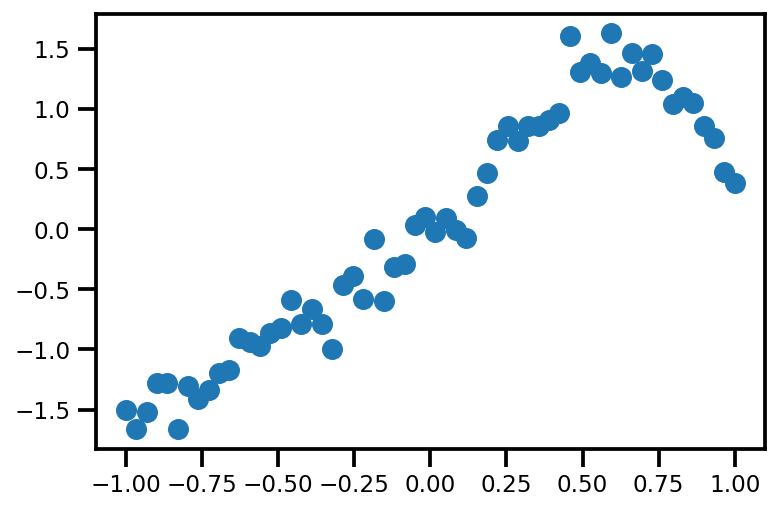

In [ ]:
n_train = 60
input_noise = 0.0
output_noise = 0.1
n_test = 100

X, Y, Xtest = get_data(
    n_train=n_train, 
    input_noise=0.0, output_noise=output_noise, 
    n_test=n_test
)

fig, ax = plt.subplots()
ax.scatter(X, Y)

plt.show()

## Gaussian Process Model

In [ ]:
import objax



# squared euclidean distance
def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return np.sum((x - y) ** 2)

# distance matrix
def distmat(func: Callable, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)

# 1D covariance matrix
def rbf_kernel(X, Y, variance, length_scale):
    # distance formula
    deltaXsq = distmat(sqeuclidean_distance, X / length_scale, Y / length_scale)

    # rbf function
    K = variance * np.exp(-0.5 * deltaXsq)
    return K

class ExactGP(objax.Module):
    def __init__(self):
        self.var = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
        self.scale = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
        self.sigma = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)
        

    def model2(self, X, y=None):
        # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
        # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
        # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

        # Compute kernel
        K = rbf_kernel(X, X, self.var, self.scale)
        K += np.eye(X.shape[0]) * np.power(self.sigma, 2)

        # Sample y according to the standard gaussian process formula
        return numpyro.sample("y", dist.MultivariateNormal(
            loc=np.zeros(X.shape[0]),
            covariance_matrix=K), obs=y
        )

    def guide(self, X, y):
        pass


    def model(self, X, y=None):
        η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
        ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
        σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

        # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
        # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
        # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

        # Compute kernel
        K = rbf_kernel(X, X, η, ℓ)
        K += np.eye(X.shape[0]) * np.power(σ, 2)

        # Sample y according to the standard gaussian process formula
        return numpyro.sample("y", dist.MultivariateNormal(
            loc=np.zeros(X.shape[0]),
            covariance_matrix=K), obs=y
        )

    def guide(self, X, y):
        pass



In [ ]:



# GP model.
def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    # η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
    # ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
    # σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

    η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

    # Compute kernel
    K = rbf_kernel(X, X, η, ℓ)
    K += np.eye(X.shape[0]) * np.power(σ, 2)

    # Sample y according to the standard gaussian process formula
    return numpyro.sample("y", dist.MultivariateNormal(
        loc=np.zeros(X.shape[0]),
        covariance_matrix=K), obs=y
    )

def empty_guide(X, y):
    pass


def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, bool]:
    """Cholesky Factorization"""
    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)

    return L, weights

# Predictive Mean and Variance
def predict(X, Y, X_test, variance, length_scale, noise):

    K = rbf_kernel(X, X, variance, length_scale)
    L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

    # Calculate the Mean
    K_x = rbf_kernel(X_test, X, variance, length_scale)
    mu_y = np.dot(K_x, alpha)

    # Calculate the variance
    v = jax.scipy.linalg.cho_solve(L, K_x.T)

    # Calculate kernel matrix for inputs
    K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

    cov_y = K_xx - np.dot(K_x, v)
    return mu_y, cov_y


# Summarize function posterior.
def posterior(rng_key, X, Y, X_test, variance, length_scale, noise):
    m, cov = predict(X, Y, X_test, variance, length_scale, noise)

    return random.multivariate_normal(rng_key, mean=m, cov=cov)

def summarize_posterior(preds, ci=96):
    ci_lower = (100 - ci) / 2
    ci_upper = (100 + ci) / 2
    preds_mean = preds.mean(0)
    preds_lower = np.percentile(preds, ci_lower, axis=0)
    preds_upper = np.percentile(preds, ci_upper, axis=0)
    return preds_mean, preds_lower, preds_upper

In [ ]:
K = rbf_kernel(X, X, 1.0, 1.0)

# check shape
chex.assert_shape(K, (n_train, n_train))

## Exact GP - Maximum Marginal Likelihood

In [ ]:
from numpyro.infer.autoguide import AutoDelta#AutoDiagonalNormal, AutoIAFNormal, AutoLaplaceApproximation, AutoMultivariateNormal

In [ ]:
type(gp_model.var)

float

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

gp_model = ExactGP()

# Setup
# guide = numpyro.infer.autoguide.AutoDelta(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(gp_model.model, gp_model.guide, optimizer, loss=Trace_ELBO())
params, losses = svi.run(random.PRNGKey(1), 1_000, X, Y.squeeze())

100%|██████████| 1000/1000 [00:03<00:00, 326.51it/s, init loss: 3109.8708, avg. loss [951-1000]: -8.4157]


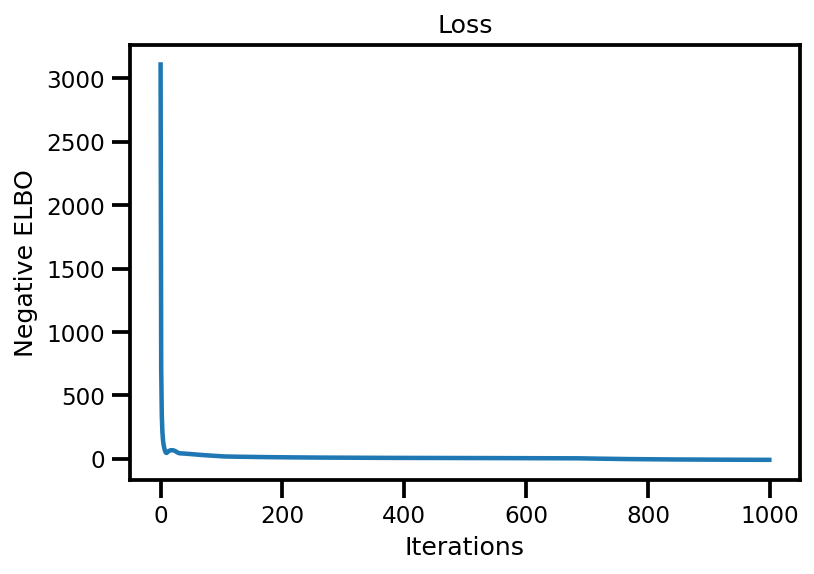

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
params

{'kernel_length': DeviceArray(0.343, dtype=float32),
 'kernel_var': DeviceArray(0.588, dtype=float32),
 'sigma': DeviceArray(0.148, dtype=float32)}

In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=params['kernel_var'], 
    length_scale=params['kernel_length'], 
    noise=params['sigma']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

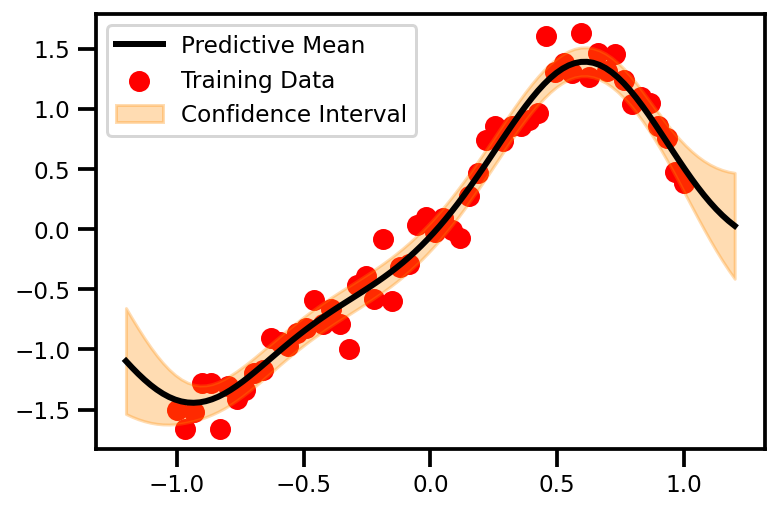

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

In [ ]:
predictive = numpyro.infer.Predictive(gp_model.model, guide=gp_model.guide, params=params, num_samples=100)

y_dist = predictive(jax.random.PRNGKey(1), X, Y)['y'].copy()

In [ ]:
y_pred.squeeze().shape

(100, 60)

In [ ]:
y_lb, y_mu, y_ub = np.percentile(y_pred, [0.05, 0.5, 0.95], axis=0)

In [ ]:
y_lb.shape

(60, 1)

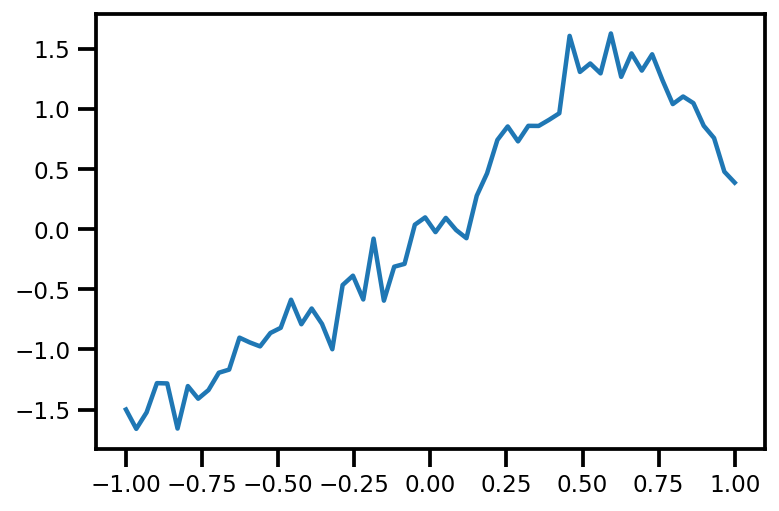

In [ ]:
plt.plot(X, Y)

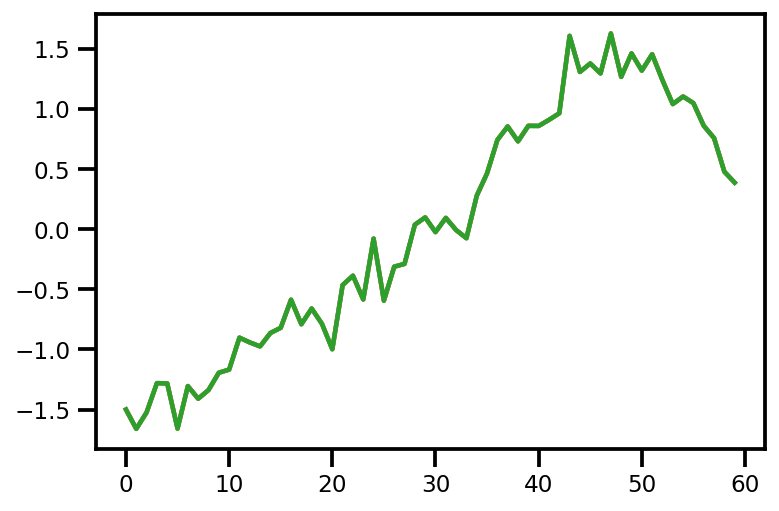

In [ ]:
plt.plot(y_mu)
plt.plot(y_ub)
plt.plot(y_lb)

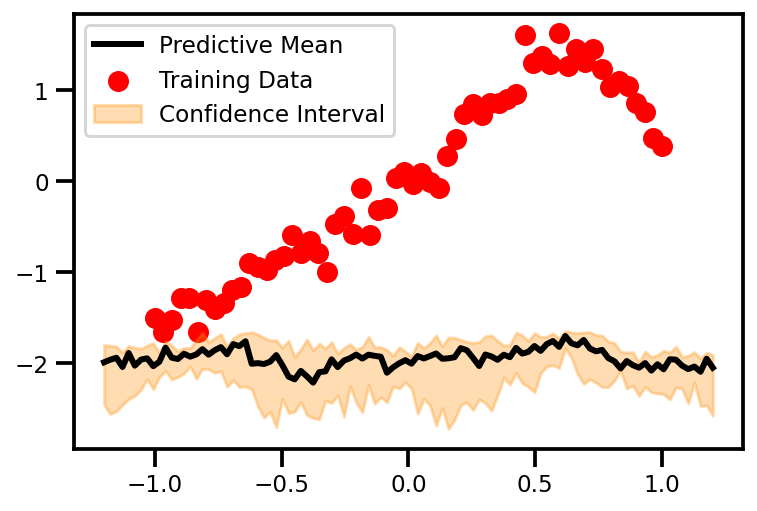

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_mu, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_lb.squeeze(),
    y_ub.squeeze(),
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

In [ ]:
key.shape, len(subkeys)

((2,), 10)

In [ ]:
key = jax.random.PRNGKey(123)

n_samples = 10
key, *subkeys = jax.random.split(key, num=n_samples+1)
samples = []
for ikey in subkeys:
  
    with numpyro.handlers.seed(rng_seed=ikey, ):
        samples.append(gp_model.model(X, None))


samples  =  np.vstack(samples)

In [ ]:
samples.shape

(10, 60)

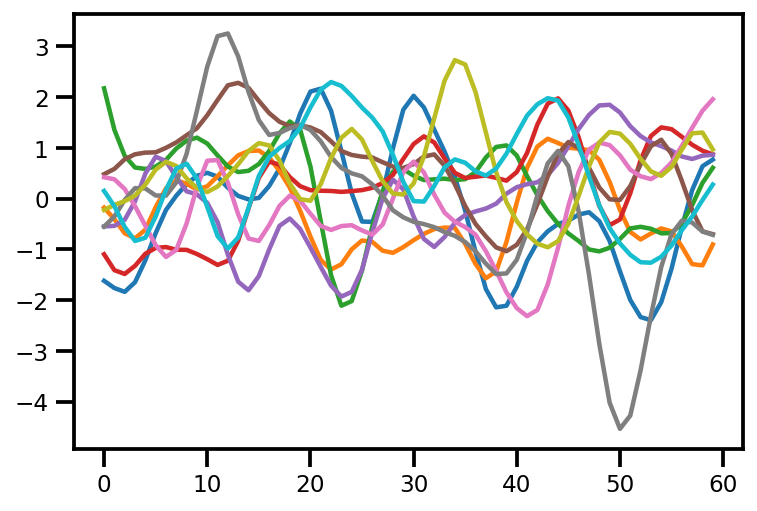

In [ ]:
plt.plot(samples.T)

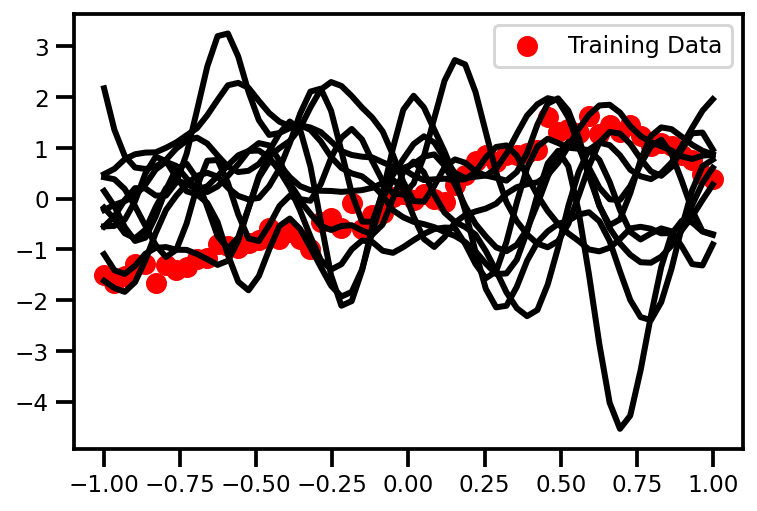

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(X, samples.T, color='black', linewidth=3)
# ax.fill_between(
#     Xtest.squeeze(),
#     y_pred - y_std,
#     y_pred + y_std,
#     label='Confidence Interval',
#     alpha=0.3,
#     color='darkorange'
#     )
ax.legend()

In [ ]:
samples[0].shape

(60, 1)

In [ ]:
samples.shape

(60, 1)

In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=params['variance_auto_loc'], 
    length_scale=params['length_scale_auto_loc'], 
    noise=params['noise_auto_loc']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

KeyError: ignored

## Laplace Approximation

In [ ]:
from numpyro.infer.autoguide import AutoLaplaceApproximation

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

# Setup
guide = numpyro.infer.autoguide.AutoLaplaceApproximation(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(GP, guide, optimizer, loss=Trace_ELBO())
params, losses = svi.run(random.PRNGKey(1), 1_000, X, Y.squeeze())

100%|██████████| 1000/1000 [00:02<00:00, 440.43it/s, init loss: 12.4653, avg. loss [951-1000]: -3.8011]


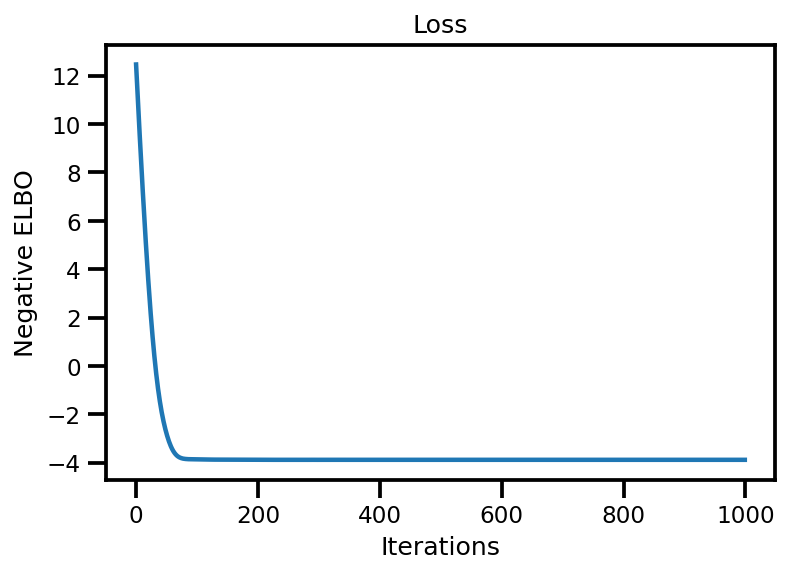

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
params
print(params)

quantiles = guide.quantiles(params, 0.5) 
print(quantiles)

{'auto_loc': DeviceArray([-0.537, -1.856,  0.959], dtype=float32)}
{'length_scale': DeviceArray(0.585, dtype=float32), 'noise': DeviceArray(0.156, dtype=float32), 'variance': DeviceArray(2.61, dtype=float32)}


In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=quantiles['variance'], 
    length_scale=quantiles['length_scale'], 
    noise=quantiles['noise']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

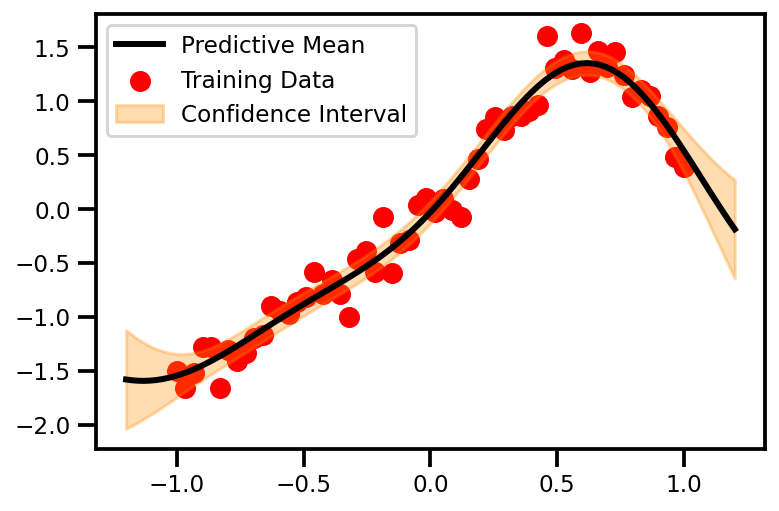

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

In [ ]:
def sample_posterior(guide, params, nsamples, seed=1):
    samples = guide.get_posterior(params).sample(
        random.PRNGKey(seed), (nsamples, ))
    # NOTE: Samples are arranged in alphabetical order.
    #       Not in the order in which they appear in the
    #       model. This is different from pyro.
    # return dict(variance=samples[:, 1],  # kernel_variance
    #             length_scale=samples[:, 0],  # kernel_length 
    #             noise=samples[:, 2])  # sigma
    return dict(length_scale=np.exp(samples[:, 0]),
                noise=np.exp(samples[:, 1]),
                
                variance=np.exp(samples[:, 2])
                ) 

In [ ]:
quantiles = guide.quantiles(params, 0.5) 

In [ ]:
quantiles

{'length_scale': DeviceArray(0.585, dtype=float32),
 'noise': DeviceArray(0.156, dtype=float32),
 'variance': DeviceArray(2.61, dtype=float32)}

In [ ]:
%%time
optimal_state, loss = svi.update(init_state, X, Y.squeeze())
params = svi.get_params(optimal_state)
print(params)

quantiles = guide.quantiles(params, 0.5) 
print(quantiles)

{'auto_loc': DeviceArray([-0.537, -1.856,  0.96 ], dtype=float32)}
{'length_scale': DeviceArray(0.585, dtype=float32), 'noise': DeviceArray(0.156, dtype=float32), 'variance': DeviceArray(2.612, dtype=float32)}
CPU times: user 5.55 s, sys: 474 ms, total: 6.02 s
Wall time: 5.57 s


In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=quantiles['variance'], 
    length_scale=quantiles['length_scale'], 
    noise=quantiles['noise']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

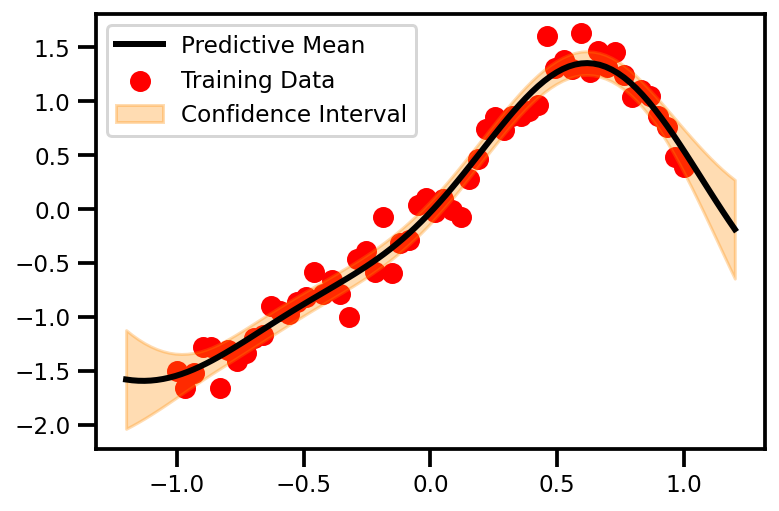

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

#### SGD

In [ ]:
def GP(X, y):
    # Set informative log-normal priors on kernel hyperparameters.
    # η = pm.HalfCauchy("η", beta=5)
    η = numpyro.sample("variance", dist.HalfCauchy(scale=5.))
    ℓ = numpyro.sample("length_scale", dist.Gamma(2., 1.))
    σ = numpyro.sample("noise", dist.HalfCauchy(scale=5.))

    # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    # ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    # σ = numpyro.param("sigma", init_value=0.01, onstraints=dist.constraints.positive)

    # Compute kernel
    K = rbf_kernel(X, X, η, ℓ)
    K += np.eye(X.shape[0]) * np.power(σ, 2)

    # Sample y according to the standard gaussian process formula
    numpyro.sample("y", dist.MultivariateNormal(
        loc=np.zeros(X.shape[0]),
        covariance_matrix=K), obs=y
    )

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

# Setup
guide = numpyro.infer.autoguide.AutoLaplaceApproximation(GP)
# optimizer = numpyro.optim.Adam(step_size=0.01)
optimizer = numpyro.optim.SGD(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(GP, guide, optimizer, loss=Trace_ELBO())
init_state = svi.init(random.PRNGKey(1), X, Y.squeeze())

In [ ]:
%%time
n_epochs = 1_000
# Run optimizer for 1000 iteratons.
state, losses = jax.lax.scan(
    lambda state, i: svi.update(state, X, Y.squeeze()),
    init_state, np.arange(1_000)
)



CPU times: user 1.39 s, sys: 4.31 ms, total: 1.39 s
Wall time: 1.39 s


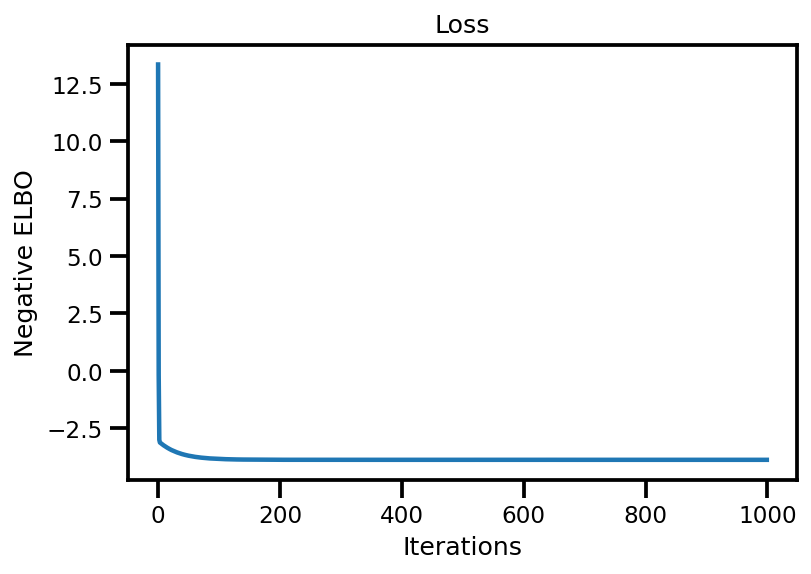

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
%%time
optimal_state, loss = svi.update(init_state, X, Y.squeeze())
params = svi.get_params(optimal_state)
print(params)

quantiles = guide.quantiles(params, 0.5) 
print(quantiles)

{'auto_loc': DeviceArray([-0.446, -1.606,  1.983], dtype=float32)}
{'length_scale': DeviceArray(0.64, dtype=float32), 'noise': DeviceArray(0.201, dtype=float32), 'variance': DeviceArray(7.266, dtype=float32)}
CPU times: user 662 ms, sys: 322 ms, total: 984 ms
Wall time: 635 ms


In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=quantiles['variance'], 
    length_scale=quantiles['length_scale'], 
    noise=quantiles['noise']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

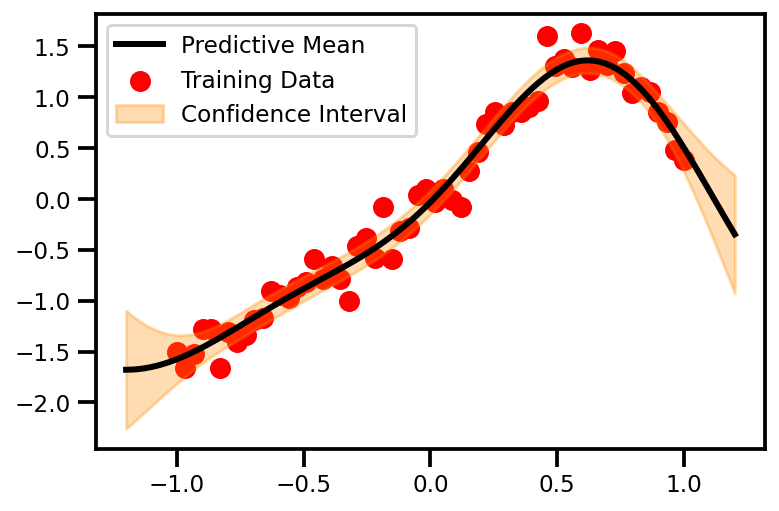

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()

## Mean Field Approximation

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

# Setup
guide = numpyro.infer.autoguide.AutoDiagonalNormal(GP)
# optimizer = numpyro.optim.Adam(step_size=0.01)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(GP, guide, optimizer, loss=Trace_ELBO())
init_state = svi.init(random.PRNGKey(1), X, Y.squeeze())

In [ ]:
%%time
n_epochs = 1_000
# Run optimizer for 1000 iteratons.
state, losses = jax.lax.scan(
    lambda state, i: svi.update(state, X, Y.squeeze()),
    init_state, np.arange(1_000)
)


CPU times: user 1.87 s, sys: 2.99 ms, total: 1.87 s
Wall time: 1.87 s


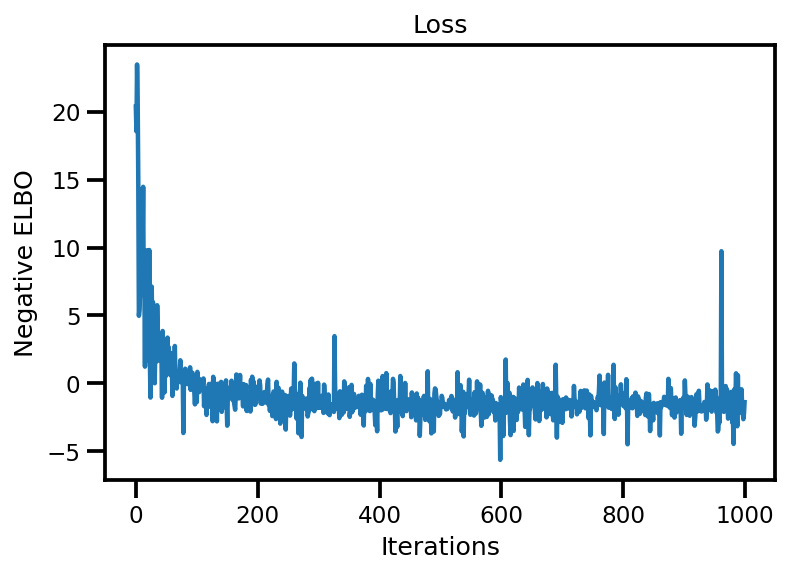

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
%%time
optimal_state, loss = svi.update(init_state, X, Y.squeeze())
params = svi.get_params(optimal_state)
print(params)

quantiles = guide.quantiles(params, 0.5) 
print(quantiles)

{'auto_loc': DeviceArray([ 0.147, -1.847,  1.913], dtype=float32), 'auto_scale': DeviceArray([0.099, 0.099, 0.101], dtype=float32)}
{'length_scale': DeviceArray(1.158, dtype=float32), 'noise': DeviceArray(0.158, dtype=float32), 'variance': DeviceArray(6.774, dtype=float32)}
CPU times: user 164 ms, sys: 145 ms, total: 309 ms
Wall time: 176 ms


In [ ]:
def sample_posterior(guide, params, nsamples, seed=1):
    samples = guide.get_posterior(params).sample(
        random.PRNGKey(seed), (nsamples, ))
    # NOTE: Samples are arranged in alphabetical order.
    #       Not in the order in which they appear in the
    #       model. This is different from pyro.
    # return dict(variance=samples[:, 1],  # kernel_variance
    #             length_scale=samples[:, 0],  # kernel_length 
    #             noise=samples[:, 2])  # sigma
    return dict(length_scale=np.exp(samples[:, 0]),
                noise=np.exp(samples[:, 1]),
                variance=np.exp(samples[:, 2])
                ) 
advi_samples = sample_posterior(guide, params, 1_000, 123)


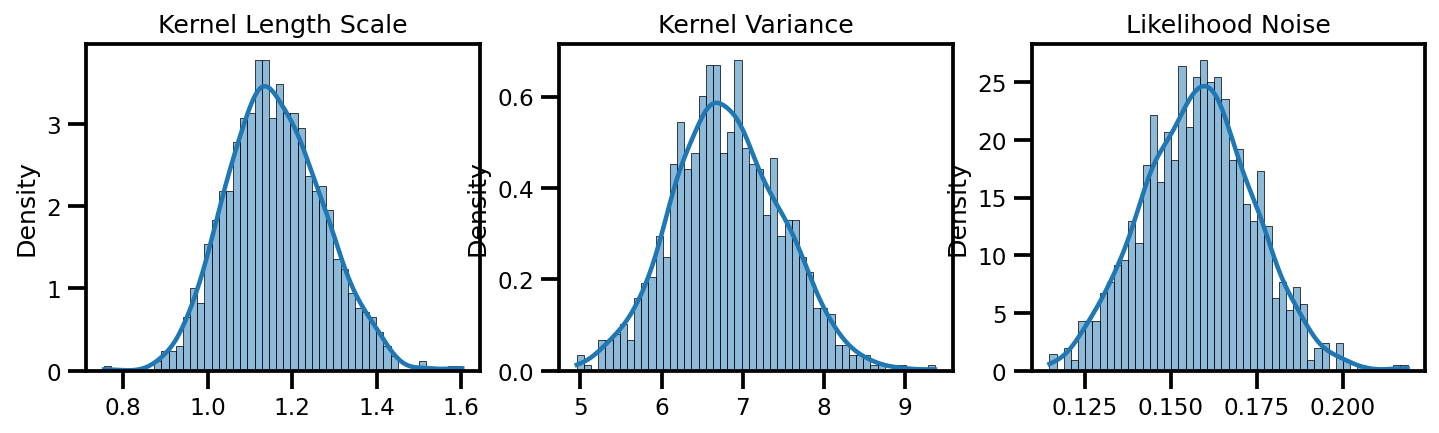

In [ ]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=advi_samples['length_scale'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[1], x=advi_samples['variance'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[2], x=advi_samples['noise'], kde=True, bins=50, stat='density')

ax[0].set_title('Kernel Length Scale')
ax[1].set_title('Kernel Variance')
ax[2].set_title('Likelihood Noise')

plt.show()

In [ ]:
%%time
n_epochs = 1_000
# Run optimizer for 1000 iteratons.
state, losses = jax.lax.scan(
    lambda state, i: svi.update(state, X, Y.squeeze()),
    init_state, np.arange(1_000)
)

CPU times: user 1.93 s, sys: 3.62 ms, total: 1.93 s
Wall time: 1.93 s


## Full Posterior

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)

# Setup
guide = numpyro.infer.autoguide.AutoLowRankMultivariateNormal(GP)
optimizer = numpyro.optim.Adam(step_size=0.01)
# optimizer = numpyro.optim.SGD(step_size=0.01)
# optimizer = numpyro.optim.Minimize()
# optimizer = optax.adamw(learning_rate=0.1)
svi = SVI(GP, guide, optimizer, loss=Trace_ELBO())
init_state = svi.init(random.PRNGKey(1), X, Y.squeeze())

In [ ]:
%%time
n_epochs = 1_000
# Run optimizer for 1000 iteratons.
state, losses = jax.lax.scan(
    lambda state, i: svi.update(state, X, Y.squeeze()),
    init_state, np.arange(1_000)
)

CPU times: user 2.54 s, sys: 14.8 ms, total: 2.55 s
Wall time: 2.55 s


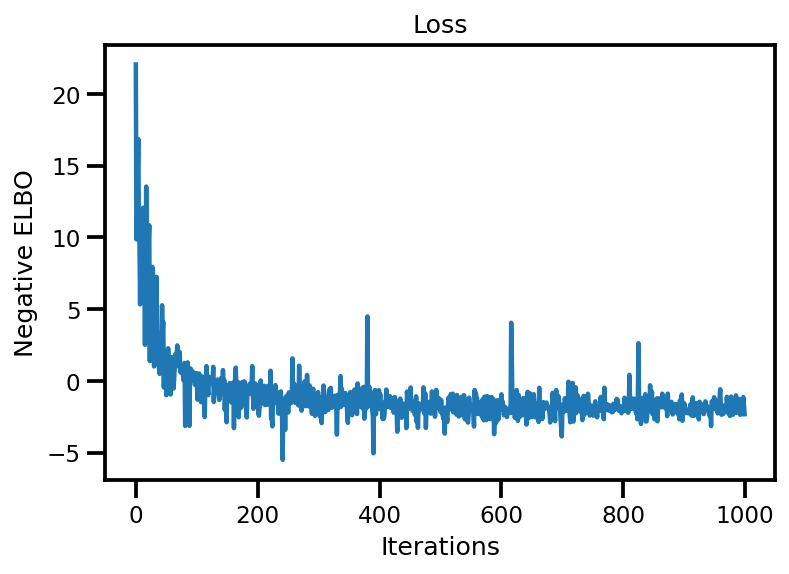

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
%%time
optimal_state, loss = svi.update(init_state, X, Y.squeeze())
params = svi.get_params(optimal_state)
print(params)

quantiles = guide.quantiles(params, 0.5) 
print(quantiles)

{'auto_cov_factor': DeviceArray([[ 0.01, -0.01],
             [-0.01,  0.01],
             [-0.01,  0.01]], dtype=float32), 'auto_loc': DeviceArray([ 0.147, -1.847,  1.913], dtype=float32), 'auto_scale': DeviceArray([0.099, 0.101, 0.101], dtype=float32)}
{'length_scale': DeviceArray(1.158, dtype=float32), 'noise': DeviceArray(0.158, dtype=float32), 'variance': DeviceArray(6.774, dtype=float32)}
CPU times: user 737 ms, sys: 205 ms, total: 942 ms
Wall time: 704 ms


In [ ]:
advi_samples = sample_posterior(guide, params, 1_000, 123, )

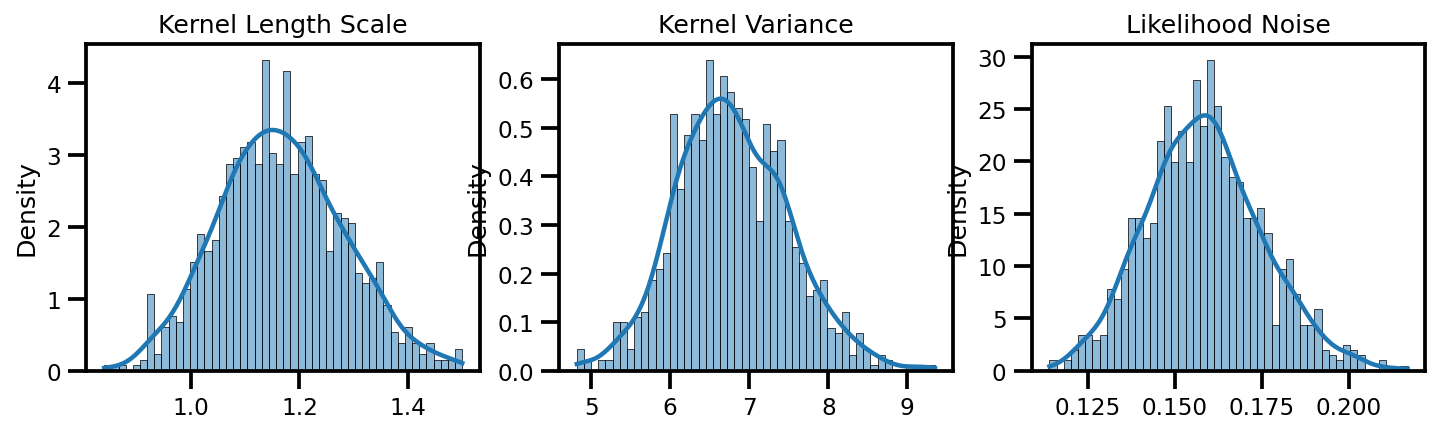

In [ ]:
# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=advi_samples['length_scale'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[1], x=advi_samples['variance'], kde=True, bins=50, stat='density')
sns.histplot(ax=ax[2], x=advi_samples['noise'], kde=True, bins=50, stat='density')

ax[0].set_title('Kernel Length Scale')
ax[1].set_title('Kernel Variance')
ax[2].set_title('Likelihood Noise')

plt.show()

In [ ]:
def sample_posterior(guide, params, nsamples, seed=1):
    samples = guide.get_posterior(params).sample(
        random.PRNGKey(seed), (nsamples, ))
    # NOTE: Samples are arranged in alphabetical order.
    #       Not in the order in which they appear in the
    #       model. This is different from pyro.
    return dict(length_scale=samples[:, 0],  # kernel_length
                variance=samples[:, 1],  # kernel_variance
                noise=samples[:, 2])  # sigma
    # return samples
# quantiles = guide.quantiles(params, 0.5) 

seed = 123
n_samples = 1_000

advi_samples = guide.get_posterior(params).sample(random.PRNGKey(seed), (1_000, ))



In [ ]:
samples = guide.get_posterior(params).sample(random.PRNGKey(123), (1_000, ))

In [ ]:
advi_samples

DeviceArray([[-0.612, -1.609,  1.91 ],
             [-0.501, -1.639,  1.798],
             [-0.56 , -1.338,  2.06 ],
             ...,
             [-0.483, -1.415,  2.123],
             [-0.424, -1.455,  1.893],
             [-0.575, -1.452,  2.075]], dtype=float32)

In [ ]:
quantiles, advi_samples

({'kernel_length': DeviceArray(0.593, dtype=float32),
  'kernel_var': DeviceArray(2.29, dtype=float32),
  'sigma': DeviceArray(0.169, dtype=float32)},
 DeviceArray([[-0.553,  1.087, -1.538]], dtype=float32))

In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=quantiles['kernel_var'], 
    length_scale=quantiles['kernel_length'], 
    noise=quantiles['sigma']
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

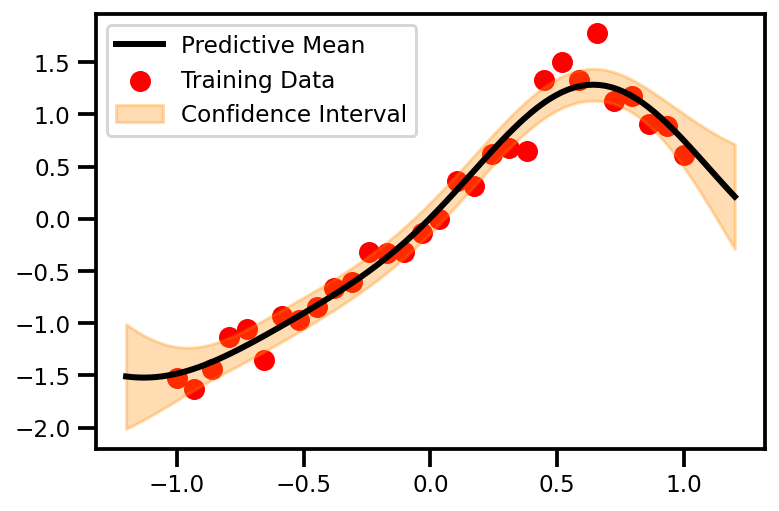

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()
plt.show()

## Variational Inference

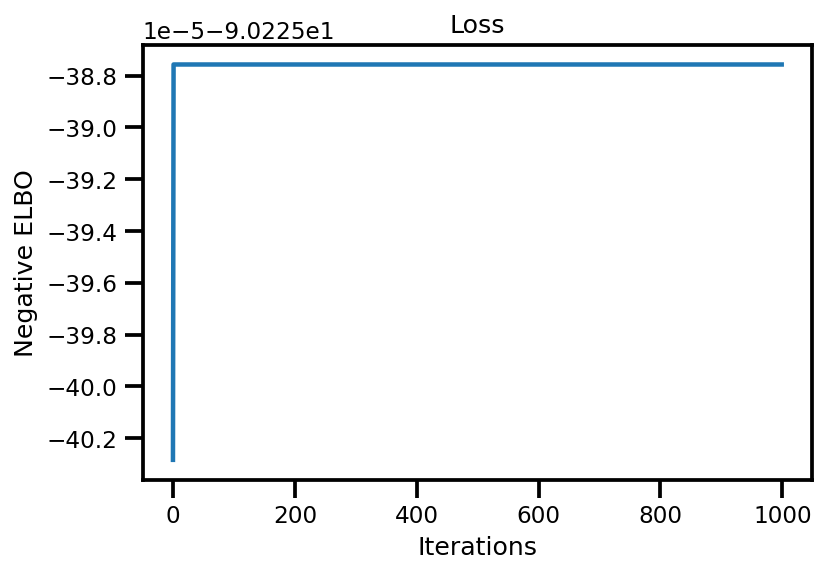

IndexError: ignored

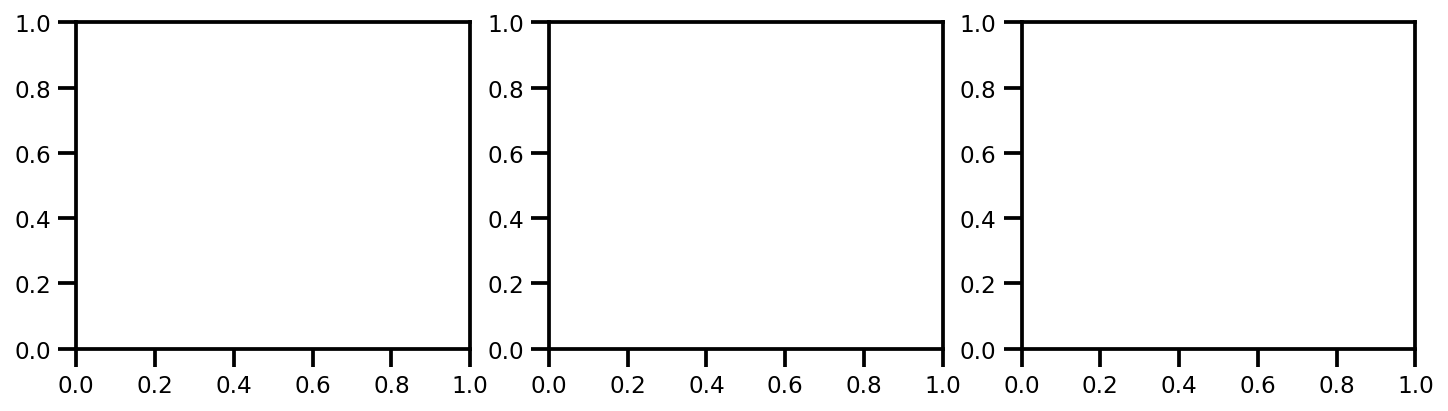

In [ ]:
fig, ax = plt.subplots()

ax.plot(losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

# Plot posteriors for the parameers
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=advi_samples['length_scale'], kde=True, stat='density')
sns.histplot(ax=ax[1], x=advi_samples['variance'], kde=True, stat='density')
sns.histplot(ax=ax[2], x=advi_samples['noise'], kde=True, stat='density')

ax[0].set_title('Kernel Length Scale')
ax[1].set_title('Kernel Variance')
ax[2].set_title('Likelihood Noise')

plt.show()

In [ ]:
y_pred, y_cov = predict(
    X, Y.squeeze(), Xtest, 
    variance=advi_samples['variance'].mean(), 
    length_scale=advi_samples['length_scale'].mean(), 
    noise=advi_samples['noise'].mean()
)

y_var = np.diagonal(y_cov)
y_std = np.sqrt(y_var)

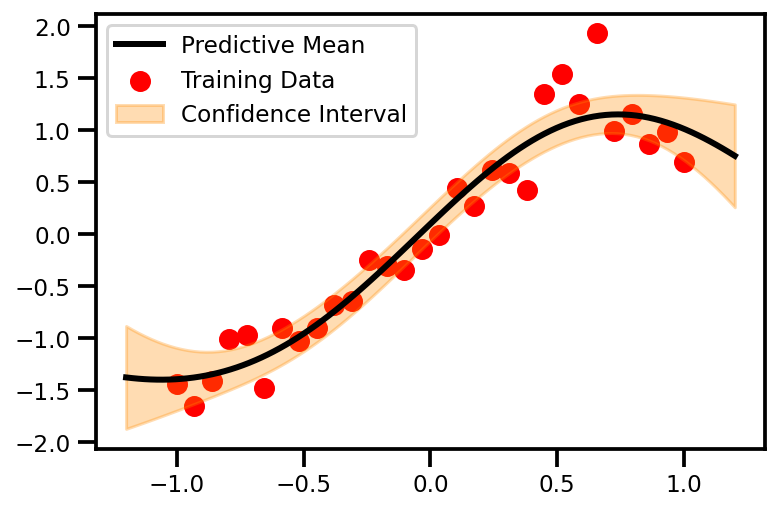

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(),
    y_pred - y_std,
    y_pred + y_std,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()
plt.show()

In [ ]:
predictions, _ = jax.vmap(predict, in_axes=(None, None, None, 0, 0, 0), out_axes=(0, 0))(
    X, Y.squeeze(), Xtest,
    advi_samples['variance'],
    advi_samples['length_scale'],
    advi_samples['noise']
    )

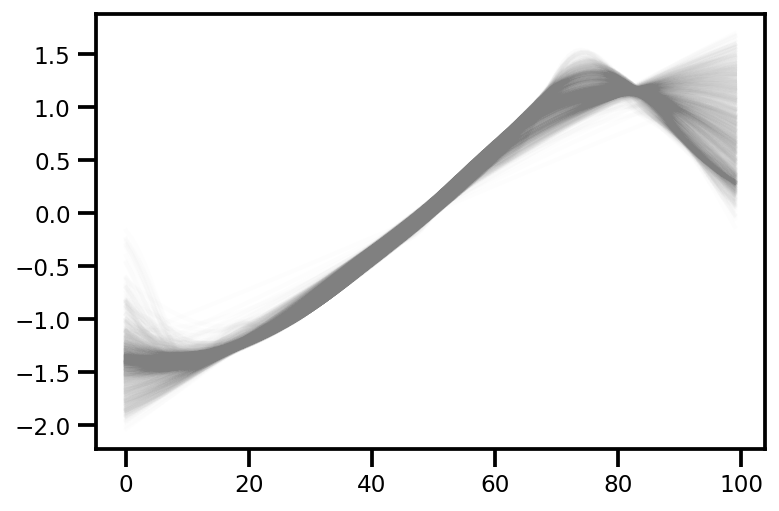

In [ ]:
plt.plot(predictions.T, color='gray', alpha=0.01);

## MCMC

In [ ]:
from numpyro.infer import MCMC, NUTS, HMC

In [ ]:
%%time

n_samples = 1_000
n_warmup = 100

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(GP)

nuts = MCMC(kernel, num_samples=n_samples, num_warmup=n_warmup)
nuts.run(rng_key, X, Y.squeeze())
nuts.print_summary()

sample: 100%|██████████| 1100/1100 [00:11<00:00, 94.82it/s, 7 steps of size 4.20e-01. acc. prob=0.95]  



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
  length_scale      0.59      0.10      0.58      0.42      0.73    459.74      1.00
         noise      0.16      0.02      0.16      0.13      0.19    632.75      1.00
      variance      4.10      4.62      2.75      0.31      8.36    383.01      1.00

Number of divergences: 0
CPU times: user 12.5 s, sys: 3.57 s, total: 16.1 s
Wall time: 11.8 s


In [ ]:
%%time

nuts_samples = nuts.get_samples()
nuts_samples = dict(
    length_scale=nuts_samples['length_scale'], 
    variance=nuts_samples['variance'],
    noise=nuts_samples['noise']
    )

CPU times: user 58 µs, sys: 9 µs, total: 67 µs
Wall time: 71 µs


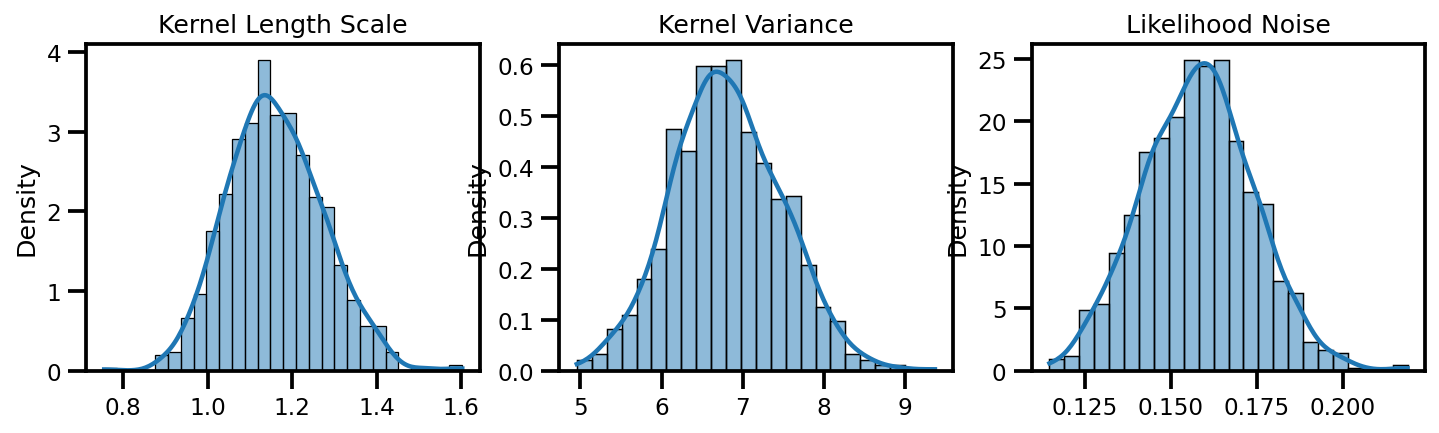

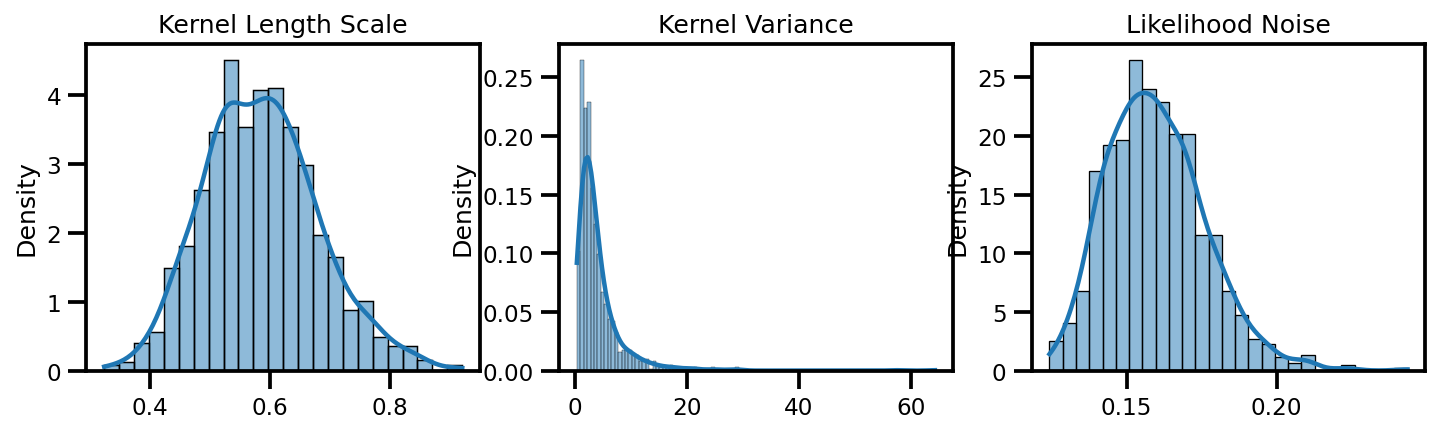

In [ ]:
# Plot posteriors for the parameters
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=advi_samples['length_scale'], kde=True, stat='density')
sns.histplot(ax=ax[1], x=advi_samples['variance'], kde=True, stat='density')
sns.histplot(ax=ax[2], x=advi_samples['noise'], kde=True, stat='density')

ax[0].set_title('Kernel Length Scale')
ax[1].set_title('Kernel Variance')
ax[2].set_title('Likelihood Noise')

plt.show()

# Plot posteriors for the parameters
fig, ax = plt.subplots(ncols=3, figsize=(12, 3))

sns.histplot(ax=ax[0], x=nuts_samples['length_scale'], kde=True, stat='density')
sns.histplot(ax=ax[1], x=nuts_samples['variance'], kde=True, stat='density')
sns.histplot(ax=ax[2], x=nuts_samples['noise'], kde=True, stat='density')

ax[0].set_title('Kernel Length Scale')
ax[1].set_title('Kernel Variance')
ax[2].set_title('Likelihood Noise')

plt.show()

In [ ]:
# Predictive Mean and Variance
def predict(X, Y, X_test, variance, length_scale, noise):

    K = rbf_kernel(X, X, variance, length_scale)
    L, alpha = cholesky_factorization(K + noise * np.eye(K.shape[0]), Y)

    # Calculate the Mean
    K_x = rbf_kernel(X_test, X, variance, length_scale)
    mu_y = np.dot(K_x, alpha)

    # Calculate the variance
    v = jax.scipy.linalg.cho_solve(L, K_x.T)

    # Calculate kernel matrix for inputs
    K_xx = rbf_kernel(X_test, X_test, variance, length_scale)

    cov_y = K_xx - np.dot(K_x, v)
    return mu_y, cov_y


# Summarize function posterior.
def posterior(rng_key, X, Y, X_test, variance, length_scale, noise):
    mu_y, _ = predict(X, Y, X_test, variance, length_scale, noise)

    return mu_y

In [ ]:
mu_y = posterior(
    rng_key, 
    X, Y.squeeze(), Xtest, 
    nuts_samples['variance'][i],
    nuts_samples['length_scale'][i],
    nuts_samples['noise'][i],
    )

NameError: ignored

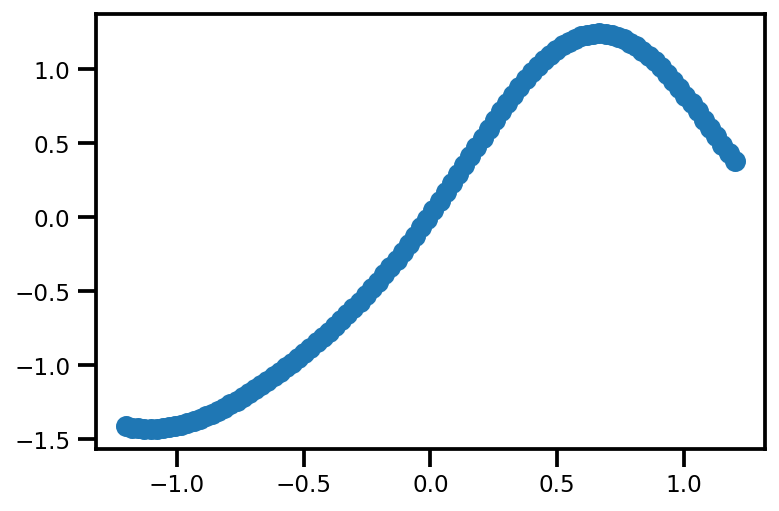

In [ ]:
plt.scatter(Xtest, mu_y)

In [ ]:
len(nuts_samples['length_scale'])

1000

In [ ]:
%%time
# make prediction function

predictions, _ = jax.vmap(predict, in_axes=(None, None, None, 0, 0, 0), out_axes=(0, 0))(
    X, Y.squeeze(), Xtest,
    nuts_samples['variance'],
    nuts_samples['length_scale'],
    nuts_samples['noise']
    )

CPU times: user 143 ms, sys: 42.2 ms, total: 185 ms
Wall time: 98.1 ms


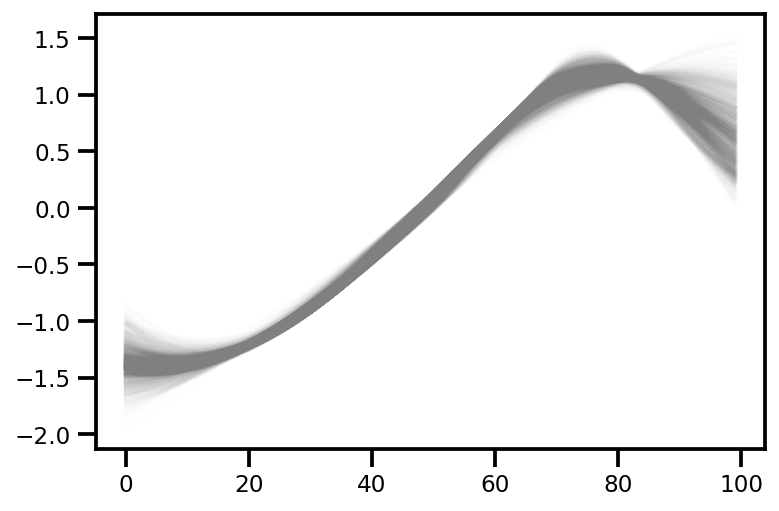

In [ ]:
plt.plot(predictions.T, color='gray', alpha=0.01);

In [ ]:
predictions.shape

(1000, 100)

In [ ]:
y_pred = np.mean(predictions, axis=0)

percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

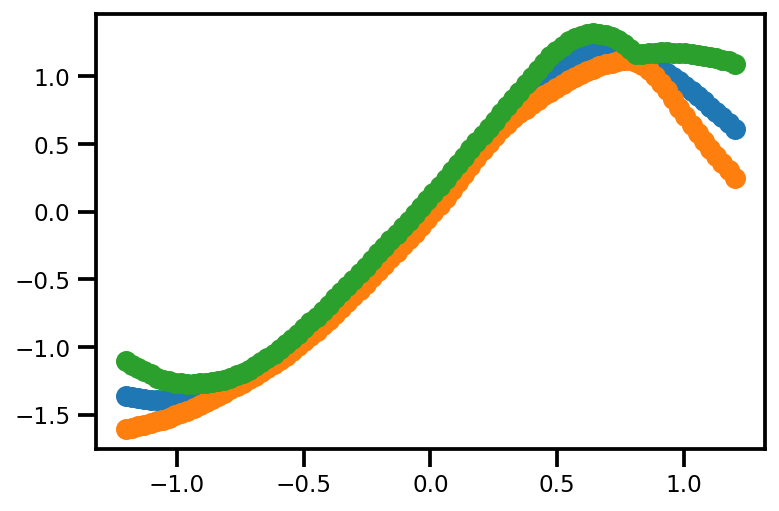

In [ ]:
plt.scatter(Xtest, y_pred)
plt.scatter(Xtest, percentiles[0])
plt.scatter(Xtest, percentiles[1])

In [ ]:
y_pred, y_lb, y_ub = summarize_posterior(predictions)

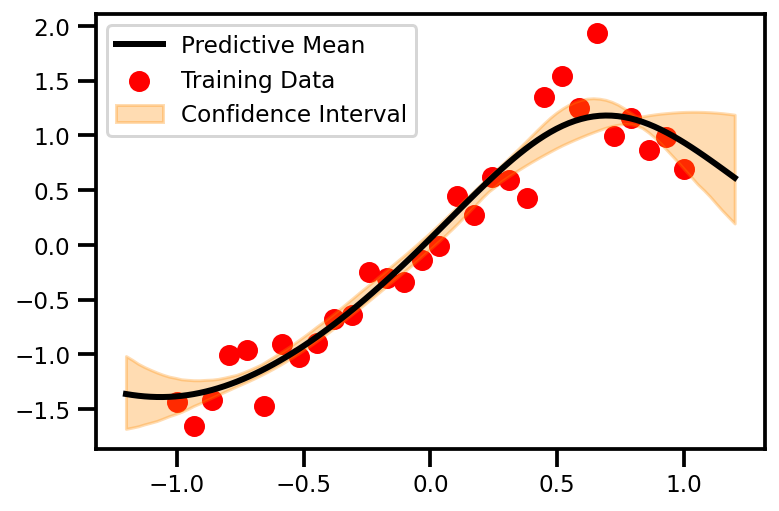

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 4))

ax.scatter(X, Y, label='Training Data', color='red')
ax.plot(Xtest, y_pred, label='Predictive Mean', color='black', linewidth=3)
ax.fill_between(
    Xtest.squeeze(), 
    y_lb, 
    y_ub,
    label='Confidence Interval',
    alpha=0.3,
    color='darkorange'
    )
ax.legend()
plt.show()

In [ ]:
y_pred, y_cov = 